## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
unique_users = df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group == "treatment" and landing_page == "old_page"').shape[0] + df.query('group == "control" and landing_page == "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info() # there is no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) ].copy()

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == "773192"') # this user was recorded in 2 different days; 2nd entry could have been accidentally recorded

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
drop_index = df2[df2.user_id.duplicated()].index
df2.drop(index=drop_index, inplace=True) #drop row with duplicate user id
df2.user_id.duplicated().sum() #confirm no more duplicate user id

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
overall_conversion = df2.converted.mean()
overall_conversion

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The above does not provide sufficient evidence that the new treatment page leads to more conversions. In fact, the test results show that the treatment group with the new page has a slightly lower conversion rate than the control group with the old page by 0.16%. However, further investigation is need to determine if this observed statistics is statistically significant as this result is just from a single sample test data collected from a limited period of time which may not cover all the possible cases.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The following hypothesis to test are:**

$$ H_0 : p_{new} - p_{old} \leq 0$$
$$ H_1 : p_{new} - p_{old} \gt 0$$

$p_{new}$ is the probability of conversion using the new page

$p_{old}$ is the probability of conversion using the old page

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = overall_conversion
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = overall_conversion
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
sample_diff = new_page_converted.mean() - old_page_converted.mean()
sample_diff

-0.00091067844926936981

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
#create list called p_diffs
p_diffs = []

#run the above stimulation 10000 times
for i in range(10000):
    new_page = np.random.binomial(1, p_new, n_new)
    old_page = np.random.binomial(1, p_old, n_old)
    diff = new_page.mean() - old_page.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

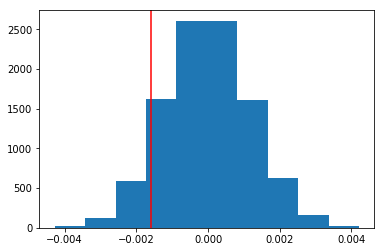

In [26]:
#make p_diffs into an array for further investigation
p_diffs = np.array(p_diffs)

#calculate the observed difference in the test results provided
obs_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
obs_diff

plt.hist(p_diffs);
plt.axvline(obs_diff, c = 'r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
(p_diffs > obs_diff).mean() # p-value is higher than 0.05

0.90480000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The p-value of 0.9 is significantly higher than the Type I error threshold of 0.05. There is no statistically signifcant evidence to rejec the null hypothesis that the old pages produce the same or more conversion rate than the new pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

#conversion numbers on each page
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()

#rows associated with each type of pages
n_old = df2.query('landing_page == "old_page"')['converted'].count()
n_new = df2.query('landing_page == "new_page"')['converted'].count()

convert_old, convert_new, n_old, n_new, convert_old/n_old, convert_new/n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310, 0.1203863045004612, 0.11880806551510564)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
#run a ztest
counts = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
stat, pval = sm.stats.proportions_ztest(counts, nobs, alternative = 'larger')
stat, pval

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score and p-value computed in the previous question is consistent with findings in part j. and k. There is no significant evidence to reject the null hypothesis that the old pages has same or more conversion rate than the new pages. The p-values in both sections are relatively the same. The z-score shows that the acutual observed conversion rate is within 1.3 standard deviation from the null mean.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since the response variable has only two outcome, logistic regression should be used.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
#first 5 rows of dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [31]:
#add intercept column
df2['intercept'] = 1

#create dummy variables for treatment and control
df_group = pd.get_dummies(df2.group)

#add the dummy variable for treatment to the dataframe df2
df2['ab_page'] = df_group['treatment']
#check the first 5 rows of the dummy variables
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
from scipy import stats #needed to resolve missing chisq function
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

#instantiate regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        22:16:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [34]:
#exponentiation the coefficient for interpretation
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [35]:
1/_

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



The p-value of the **ab_page** is 0.19, which is greater than the Type I Error rate of  0.05. This is consistent with the interpretation of the p-value in Part II. P-value in Part II is the probability that the acutual observed difference from the testing results can occur, assuming there is truly no difference in conversion between the new and old pages. The exponentiationi of p-value of **ab_page** gives us the likehood of positive response of the new pages compared to the old pages. An individual on the old page is 1.015 more likely than the new page which is barely significant. Additionally, the difference in p-value is also attributed to Part II hypothesis testing beign a one tailed test whereas the regression model is set up as an two tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is rare for a dependent variable to be explained by only one independent variable. By adding other factors in the regression, a more comprehensive analysis can be done to understand what other independent variables are correlated and have significant influence on the dependent variables. Additionally, if the scatter plot of the dataset shows a non-linear relationship, we can consider adding higher order terms to better respresent the data. However, adding higher order terms will make interpretation of the data more complex. It's also important to note that all the other factors to add must be independent to one other as p-values and cofficients will be inaccurate due to multicollinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
#read and load countries.csv
df_c = pd.read_csv('countries.csv')

#show first 5 rows of new csv
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
df_c.info() #there is no null entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [38]:
#merge DataFrame df2 with corresponding countries from df_c by user_id column
df3 = pd.merge(df2, df_c, how = 'left', on = 'user_id')

#check that all countries are populated for user_id; expect True
df2.user_id.count()==df3.country.count()

True

In [39]:
#identify the unique countries for users
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
#get dummy variables for countries
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3.country)

#confirm dummy were added in successfully
df3.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [41]:
#instantiate regression model
logit_c = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])

#fit the model
results_c = logit_c.fit()

#find summary of model
results_c.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        22:16:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [42]:
#exponentiation the coefficient for interpretation
np.exp(results_c.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [43]:
1/_

intercept    7.310207
ab_page      1.015056
CA           1.041599
UK           0.990165
dtype: float64

In [44]:
# check for interactions between ab_page and countries

df3['UK_ab_page'] = df3['UK'] * df3['ab_page']
df3['CA_ab_page'] = df3['CA'] * df3['ab_page']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,UK_ab_page,CA_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [45]:
#instantiate regression model
logit_i = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'UK_ab_page', 'CA_ab_page']])

#fit the model
results_i = logit_i.fit()

#find summary of model
results_i.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 23 Apr 2020   Pseudo R-squ.:               3.482e-05
Time:                        22:16:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

In [46]:
#exponentiation the coefficient for interpretation
np.exp(results_i.params)

intercept     0.137178
ab_page       0.979646
CA            0.982625
UK            0.994272
UK_ab_page    1.031896
CA_ab_page    0.954198
dtype: float64

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

Based on the regression model without the interaction between country and page type, the country of the users and whether users are accesssing the new or old pages does not have signficant impact on whether an user converts, as the p-values of all the independent variables are greater than the Type I error of 0.05. Since the exponentiation of cofficient of all the variables are extremely close to 1, an user on the old page is not significantly more likely to convert than an user on the new page, holding all other variables constant. The same goes for user from CA or UK in comparison to an user from US. After incorporating the interactions between page type and country, there is still no signficant impact on user conversion by on the relationship between country and page type since the exponentiation of all the cofficient is very close to 1. 

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0